## Scattered data interpolation via Covariance Regularized Reconstruction

This notebook describes and compares several methods of scattered data interpolation.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.optimize as optimize
import crr.reconstruct as reconstruct
from sampling import Sampling
from roll_zeropad import roll_zeropad
matplotlib.rcParams['font.size'] = 16

The plot below shows the sampling (with the size of the points proportional to the width of the kernel.

In [22]:
sampling = Sampling(nsamples=4000, sigmarange=[1.5, 4.5], xyrange=[-30.5, 30.5])

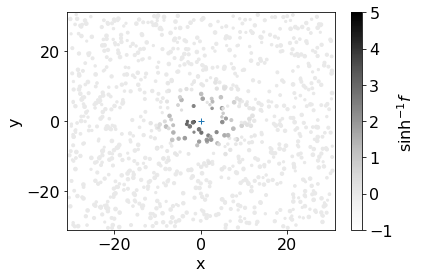

In [23]:
sampling.set_flux(total_flux=1000., noise=0.)
sampling.imshow()
plt.savefig('../tex/figures/scattered-data.png', dpi=300)

We will reconstruct on a 21 by 21 grid, with the $x$ and $y$ coordinates set below (with coordinate $(0,0)$ at pixel center $(10, 10)$), and pixels space each unit of distance in the space.

### Modelling the image

We can create a noiseless image and perform the fit. This works great. It is very closely equivalent to a full image deconvolution.

In [24]:
x = sampling.x + 30.
y = sampling.y + 30.
fivar = np.ones(len(x))
r = reconstruct.Reconstruct(x=x, y=y, nx=61, ny=61, fivar=fivar)


In [25]:
def psf(x, y, i):
    sig = sampling.sigma
    g = np.exp(- 0.5 * (x**2 + y**2) / sig**2) / (2. * np.pi * sig**2)
    return(g)
r.psf = psf

In [26]:
r.set_grid()
r.set_Amatrix()

In [27]:
r.set_weights()

In [28]:
S_G = r.apply_weights(sampling.flux)
S_G = S_G.reshape((61, 61))

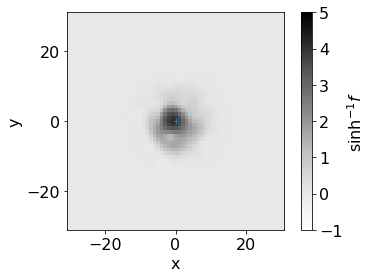

In [29]:
sampling.imshow(S_G, nopoints=True)
plt.savefig('../tex/figures/scattered-crr-noiseless.png', dpi=300)

In [4]:
x = sampling.x + 30.
y = sampling.y + 30.
fivar = np.ones(len(x))
rs = reconstruct.ReconstructStitch(x=x, y=y, nx=61, ny=61, fivar=fivar)
rs.set_grid()

In [5]:
def psf(x, y, i):
    sig = sampling.sigma
    g = np.exp(- 0.5 * (x**2 + y**2) / sig**2) / (2. * np.pi * sig**2)
    return(g)
rs.psf = psf

In [6]:
rs.set_Amatrix()

In [15]:
rs.set_patches(poverlap=10, pminsize=30)
print(rs.pxsize)

[ 7 22 38 53]
30


In [16]:
print(rs.patches)

[[( 0, 29,  0, 29) ( 0, 29,  7, 36) ( 0, 29, 23, 52) ( 0, 29, 31, 60)]
 [( 7, 36,  0, 29) ( 7, 36,  7, 36) ( 7, 36, 23, 52) ( 7, 36, 31, 60)]
 [(23, 52,  0, 29) (23, 52,  7, 36) (23, 52, 23, 52) (23, 52, 31, 60)]
 [(31, 60,  0, 29) (31, 60,  7, 36) (31, 60, 23, 52) (31, 60, 31, 60)]]


In [17]:
print(rs.pxsize)

30


In [18]:
os.cpu_count()

8

In [19]:
print(rs.npx)
rs.set_weights()

4
0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3


In [20]:
S_Gs = rs.apply_weights(sampling.flux)
S_Gs = S_Gs.reshape((61, 61))

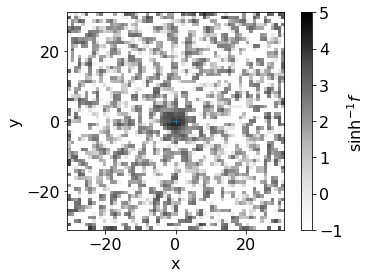

In [21]:
sampling.imshow(S_Gs, nopoints=True)
plt.savefig('../tex/figures/scattered-crr-noiseless.png', dpi=300)

In [27]:
# import multiprocessing
# multiprocessing.cpu_count()
pool = multiprocessing.Pool()
pool._processes

8

In [14]:
plt.imshow((S_Gs - S_G) / (S_G + 1.e-2), vmin=-0.5, vmax=0.5)
plt.colorbar()

NameError: name 'S_G' is not defined

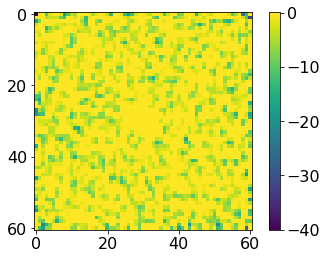

In [52]:
plt.imshow(S_Gs, vmax=0.05)
plt.colorbar()

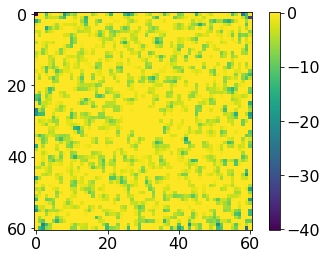

In [53]:
plt.imshow(S_G, vmax=0.05)
plt.colorbar()


In [32]:
i = 0
j = 0
gin = rs.grid_in_patch(i, j)

xfac = ((rs.xgrid.flatten()[gin] -
         rs.patches['pxst'][i, j]) /
        (rs.patches['pxnd'][i, j] -
         rs.patches['pxst'][i, j]))
weights_xapodize = np.exp(- 0.5 * (xfac - 0.5)**2 /
                         (0.15**2))
yfac = ((rs.ygrid.flatten()[gin] -
    rs.patches['pyst'][i, j]) /
    (rs.patches['pynd'][i, j] -
    rs.patches['pyst'][i, j]))
weights_yapodize = np.exp(- 0.5 * (yfac - 0.5)**2 /
    (0.15**2))
weights_apodize = weights_xapodize * weights_yapodize


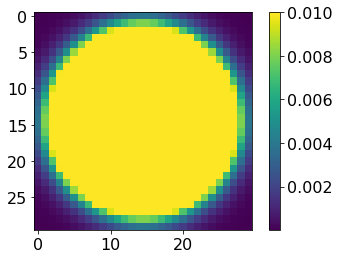

In [35]:
plt.imshow(weights_apodize.reshape(30, 30), vmax=0.01)
plt.colorbar()